# Random Forest


In [1]:
# import
import pickle

import numpy as np
np.random.seed(42)

from sklearn.model_selection import GridSearchCV,KFold 
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error, root_mean_squared_error


In [2]:
taille_fenetre_to_run = "courte"
assert taille_fenetre_to_run in ["courte","moyenne","longue"]

In [3]:
if taille_fenetre_to_run == "courte":
    data = pickle.load(open("Data/donnees_courte.pkl", "rb"))
elif taille_fenetre_to_run == "moyenne":
    data = pickle.load(open("Data/donnees_moyenne.pkl", "rb"))
else:
    data = pickle.load(open("Data/donnees_longue.pkl", "rb"))

In [4]:
data.keys()

dict_keys(['X_np_label', 'X_np_binary', 'y_np', 'X_df_label', 'X_df_binary', 'y_df'])

In [5]:
X_np_label = data["X_np_label"]
y_np = data["y_np"]

X_df_label = data["X_df_label"]
y_df = data["y_df"]


In [6]:
features_label = pickle.load(open("Data/features_label.pkl", "rb"))
features_label

{0: 'cycle_life',
 1: 'C1',
 2: 'C2',
 3: 'Q1',
 4: 'IR',
 5: 'QC',
 6: 'Tavg',
 7: 'Tmin',
 8: 'Tmax',
 9: 'chargetime',
 10: 'pulse_width',
 11: 'cycle_to_x%',
 12: 'cutoff_currents',
 13: 'charging_rest',
 14: 'after_discharging_rest',
 15: 'before_discharging_rest',
 16: 'IR_rest',
 17: 'barcode_label',
 18: 'cycle_normalized'}

In [7]:
# Vérifier que toutes les données de X_np_label sont entre 0 et 1
for i in range(X_np_label.shape[0]):
    for j in range(X_np_label.shape[1]):
        for k in range(X_np_label.shape[2]):
            if k != 17:
                assert X_np_label[i, j, k] >= 0 and X_np_label[i, j, k] <= 1

In [8]:
X_np_label.shape

(4711, 50, 19)

In [9]:
# reshape les données 3D pour les adapter à un random forest
X_reshape = X_np_label.reshape(X_np_label.shape[0], -1)

In [10]:
n_splits = 5
kf = KFold(n_splits=n_splits, random_state=42, shuffle=True) 
# LSTM : on pourrait tester stratified (surtout dans lstm où performance dépend vraiment du split) pour l'instante)

mse_scores = []
mae_scores = []
mape_scores = []
rmse_scores = []


rf = RandomForestRegressor(n_estimators=100, random_state=42)

for fold, (train_index, test_index) in enumerate(kf.split(X_reshape)):
    print(f"Running fold {fold+1}/{n_splits}")
    X_train, X_test = X_reshape[train_index], X_reshape[test_index]
    y_train, y_test = y_np[train_index], y_np[test_index]
    
    rf.fit(X_train.reshape(X_train.shape[0], -1), y_train)

    y_pred = rf.predict(X_test.reshape(X_test.shape[0], -1))

    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)

    mse_scores.append(mse)
    mae_scores.append(mae)
    mape_scores.append(mape)
    rmse_scores.append(rmse)

    # save the model to disk
    filename = f'Models/RandomForest_{taille_fenetre_to_run}_fold_{fold}.sav'
    pickle.dump(rf, open(filename, 'wb'))
    

Running fold 1/5
Running fold 2/5
Running fold 3/5
Running fold 4/5
Running fold 5/5


In [11]:
print(f"Mean MSE: {np.mean(mse_scores)}")
print(f"Mean MAE: {np.mean(mae_scores)}")
print(f"Mean MAPE: {np.mean(mape_scores)}")
print(f"Mean RMSE: {np.mean(rmse_scores)}")

Mean MSE: 0.24853822811764337
Mean MAE: 0.278908448004453
Mean MAPE: 0.0029990265106541896
Mean RMSE: 0.4864666969305317


In [12]:
print(f'MSE scores: {mse_scores}')
print(f'MAE scores: {mae_scores}')
print(f'MAPE scores: {mape_scores}')
print(f'RMSE scores: {rmse_scores}')

MSE scores: [np.float64(0.16302421755448757), np.float64(0.48777926714447445), np.float64(0.2246323130303261), np.float64(0.19978039537178555), np.float64(0.16747494748714314)]
MAE scores: [np.float64(0.2561720295922761), np.float64(0.2998241658632217), np.float64(0.29764363279876144), np.float64(0.2784366329249412), np.float64(0.2624657788430647)]
MAPE scores: [np.float64(0.002744264179255248), np.float64(0.0032424917410425157), np.float64(0.003207671722311425), np.float64(0.00298544455762819), np.float64(0.0028152603530335702)]
RMSE scores: [np.float64(0.40376257572302016), np.float64(0.6984119609116631), np.float64(0.4739539144582795), np.float64(0.44696800262634634), np.float64(0.40923703093334934)]


In [13]:
# TODO : mettre en place dans autre fichier gridsearch 
# taille de fenetre (mais on pourrait aussi tester avec 
# stride différent... à voir à quel point c'est long )
# n_estimators
# max_depth
# min_samples_split
# min_samples_leaf
# max_features
# bootstrap
# criterion
# etc

# enfaite si on fait le gridsearch sur taille de fenetre d'abord en random forest
# ensuite on peut dire qu'on utilise meme taille de fenetre / stride pour rnn et linéaire 

In [14]:
# TODO : pas prendre un modèle de la validation croisée mais 
# directement un modèle (sinon biais ?)

In [15]:
# TODO : lstm : RMSE

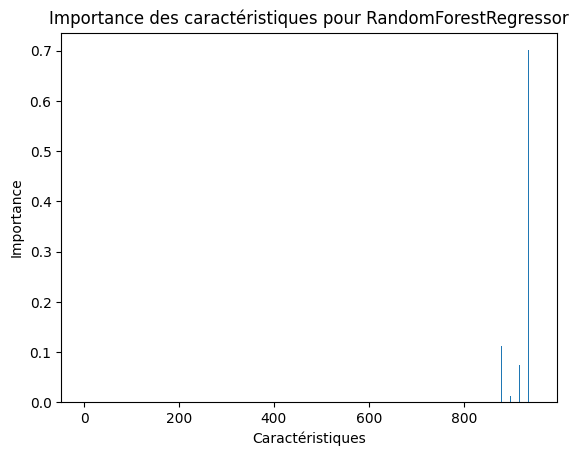

In [16]:
import matplotlib.pyplot as plt

# Récupérer l'importance des caractéristiques
feature_importances = rf.feature_importances_

# Afficher l'importance des caractéristiques sous forme de graphique
plt.bar(range(len(feature_importances)), feature_importances)
plt.xlabel('Caractéristiques')
plt.ylabel('Importance')
plt.title('Importance des caractéristiques pour RandomForestRegressor')
plt.show()


In [18]:
features_label

{0: 'cycle_life',
 1: 'C1',
 2: 'C2',
 3: 'Q1',
 4: 'IR',
 5: 'QC',
 6: 'Tavg',
 7: 'Tmin',
 8: 'Tmax',
 9: 'chargetime',
 10: 'pulse_width',
 11: 'cycle_to_x%',
 12: 'cutoff_currents',
 13: 'charging_rest',
 14: 'after_discharging_rest',
 15: 'before_discharging_rest',
 16: 'IR_rest',
 17: 'barcode_label',
 18: 'cycle_normalized'}

In [20]:
X_np_label.shape[1]

50

In [30]:
# on a 19 features (de 0 à 18, 17 est le barcode_label qui est le seul pas entre 0 et 1)
# on a reshape les données 3D pour les adapter à un random forest
# par X_reshape = X_np_label.reshape(X_np_label.shape[0], -1)
# je veux associer à chaque colonne de ce reshape le nom de la feature et à quel indice de la fenetre elle correspond

column_names = [f"{features_label[feature_idx]}_window{window_idx}" 
                for window_idx in range(X_np_label.shape[1]) 
                for feature_idx in range(len(features_label))]
print(column_names[:10])
print(column_names[-10:])

['cycle_life_window0', 'C1_window0', 'C2_window0', 'Q1_window0', 'IR_window0', 'QC_window0', 'Tavg_window0', 'Tmin_window0', 'Tmax_window0', 'chargetime_window0']
['chargetime_window49', 'pulse_width_window49', 'cycle_to_x%_window49', 'cutoff_currents_window49', 'charging_rest_window49', 'after_discharging_rest_window49', 'before_discharging_rest_window49', 'IR_rest_window49', 'barcode_label_window49', 'cycle_normalized_window49']


In [28]:
print(len(column_names))
print(X_reshape.shape[1])
print(len(feature_importances))
# ok tout semble cohérent 

950
950
950


In [ ]:
# TODO ce serait bien de regrouper par window idx et un regroupement par feature


/Users/zoemarquis/Documents/projet_industrie/projet_batteries/mon_venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


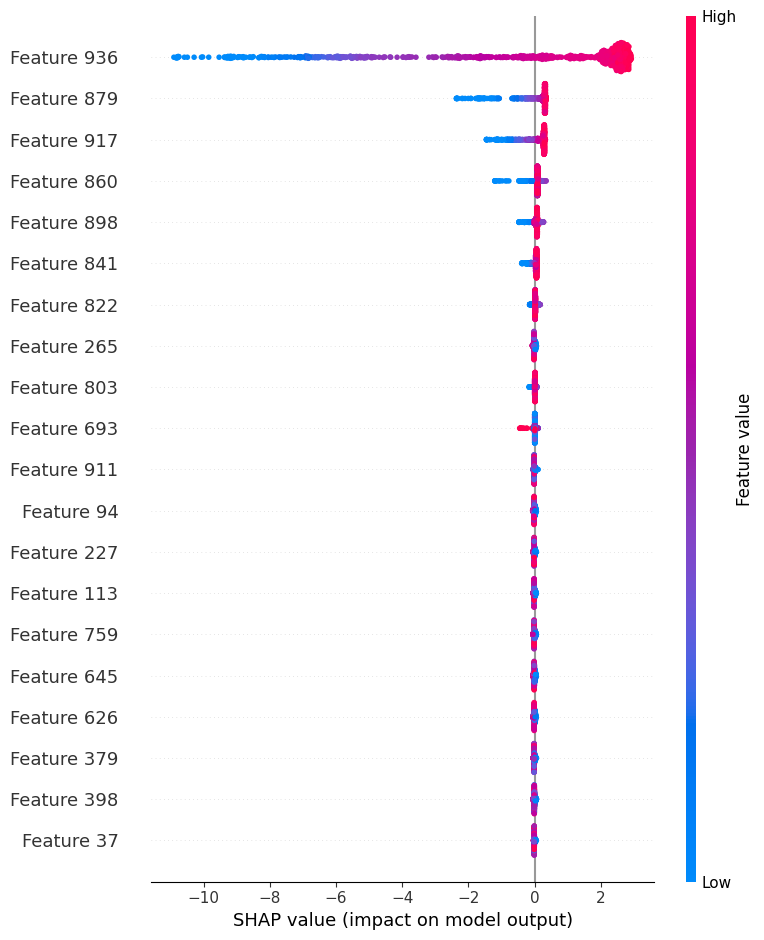

In [17]:
import shap

# Créer un explainer SHAP pour RandomForest
explainer = shap.TreeExplainer(rf)

# Calculer les valeurs SHAP pour les données de test
shap_values = explainer.shap_values(X_test)

# Visualiser les valeurs SHAP pour une prédiction
shap.initjs()  # Pour activer les visualisations interactives
shap.summary_plot(shap_values, X_test)


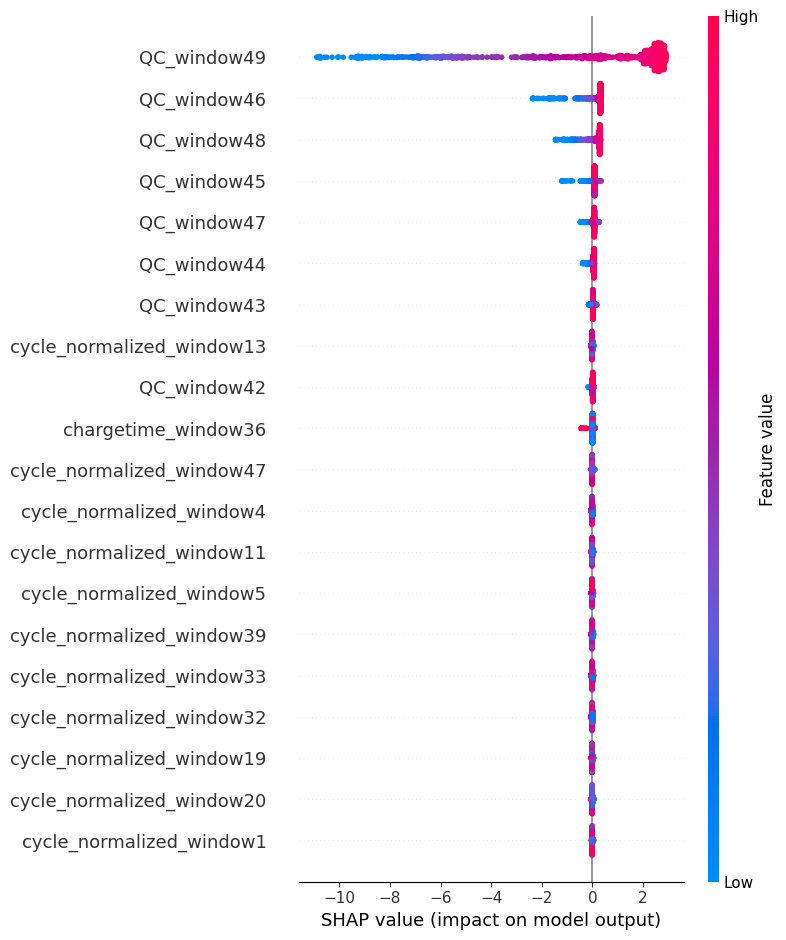

In [31]:
shap.summary_plot(shap_values, X_test, feature_names=column_names)
